# Анализ данных в задаче кредитного скоринга


In [2]:
import numpy as np
import pandas as pd
import math
from scipy.stats import chisquare
from statsmodels.stats.descriptivestats import sign_test

from statsmodels.sandbox.stats.multicomp import multipletests 

import scipy
import scipy as sc

from statsmodels.stats.weightstats import *
import pandas as pd

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

import statsmodels.stats.multitest as smm

from itertools import combinations


import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/alina/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['chisquare']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

- LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
- SEX: пол клиента (1 = мужской, 2 = женский )
- EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
- MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
- AGE: возраст в годах
- PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
- BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь
- PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
- default - индикатор невозврата денежных средств

In [3]:
data = pd.read_csv('credit_card_default_analysis.csv', sep = ',')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Задание

### 1. Размер кредитного лимита (LIMIT_BAL).
В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: 
a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки 
b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

((array([-3.70801024, -3.47700165, -3.34989414, ...,  3.34989414,
          3.47700165,  3.70801024]),
  array([ 10000,  10000,  10000, ..., 710000, 720000, 740000])),
 (106735.7693497094, 130109.65641952983, 0.9246829345320486))

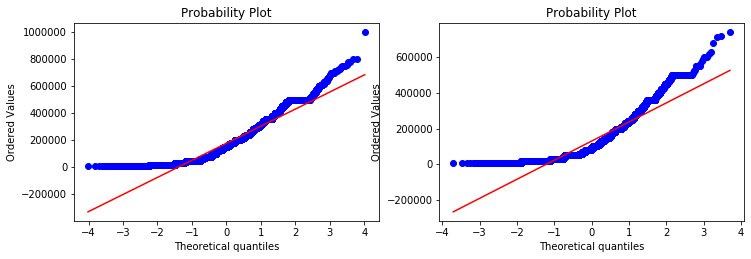

In [5]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
stats.probplot(data[data.default == 0].LIMIT_BAL, dist="norm", plot=pylab)

plt.subplot(2, 2, 2)
stats.probplot(data[data.default == 1].LIMIT_BAL, dist="norm", plot=pylab)

Распределения не являются нормальными, потому что Q-Q графики не лежат на прямой

Рассмотрим гистограммы распределений

In [6]:
data.LIMIT_BAL.describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: LIMIT_BAL, dtype: float64

Text(0, 0.5, 'Number')

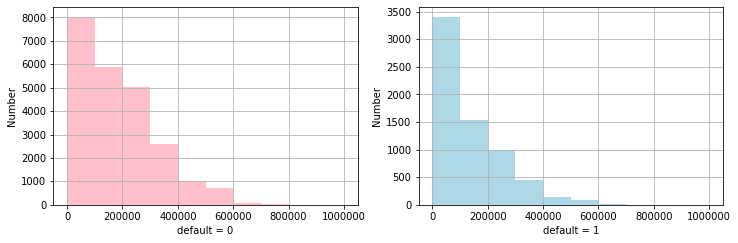

In [52]:
plt.figure(figsize = (12, 8))

plt.subplot(2,2,1)
plt.grid()
plt.hist(data[data.default == 0].LIMIT_BAL, color = 'pink', range = (0, 1000000))
plt.xlabel('default = 0')
plt.ylabel('Number')

plt.subplot(2,2,2)
plt.grid()
plt.hist(data[data.default == 1].LIMIT_BAL, color = 'lightblue', range = (0, 1000000))
plt.xlabel('default = 1')
plt.ylabel('Number')

Распределения довольно сильно отличаются друг от друга на первый взгляд и медианное значение разное. Проверим это.

In [8]:
print('Default = 0: mean = %f, median = %f'% (data[data.default == 0].LIMIT_BAL.mean(),  
                                                data[data.default == 0].LIMIT_BAL.median()))
print('Default = 1: mean = %f, median = %f'% (data[data.default == 1].LIMIT_BAL.mean(),  
                                                data[data.default == 1].LIMIT_BAL.median()))

Default = 0: mean = 178099.726074, median = 150000.000000
Default = 1: mean = 130109.656420, median = 90000.000000


#### Построим доверительный интервал на основе бутстрепа

In [9]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [10]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [11]:
np.random.seed(0)

lim_default_0 = data[data.default == 0].LIMIT_BAL.values
lim_default_1 = data[data.default == 1].LIMIT_BAL.values

median_scores_0 = list(map(np.median, get_bootstrap_samples(lim_default_0, 1000)))
median_scores_1 = list(map(np.median, get_bootstrap_samples(lim_default_1, 1000)))

print("95% confidence interval for default = 0 median:",  stat_intervals(median_scores_0, 0.05))
print("95% confidence interval for default = 1 median:",  stat_intervals(median_scores_1, 0.05))

95% confidence interval for default = 0 median: [150000. 150000.]
95% confidence interval for default = 1 median: [80000. 90000.]


In [12]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_scores_1, median_scores_0)))

print("difference between medians:", np.median(lim_default_0) - np.median(lim_default_1))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

difference between medians: 60000.0
95% confidence interval for the difference between medians [60000. 70000.]


1а. Доверительный интервал для разницы медианных значений не содержит 0, поэтому считаем разницу медианных значений статистически значимой

#### Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни
$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [13]:
stats.mannwhitneyu(lim_default_0, lim_default_1)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

1b. P_value очень маленькое, так что нулевая гипотеза уверенно отклоняется. С практической точки зрения это означает, что обычно люди, которые не могут вернуть деньги за кредит получают меньшую сумму

### 2. Пол (SEX): 
Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия)

In [14]:
data.SEX.describe()

count    30000.000000
mean         1.603733
std          0.489129
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: SEX, dtype: float64

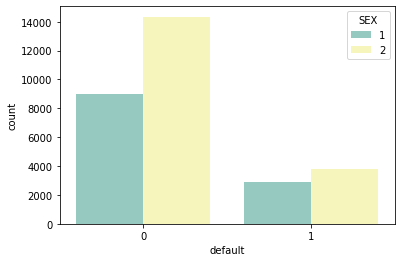

In [15]:
men = data[data.SEX == 1].default.values
women = data[data.SEX == 2].default.values

import seaborn as sns
sns.countplot(x = 'default', hue = 'SEX', data = data, palette="Set3")

Из графика видно, что женщины берут кредиты чаще и, кажется, возращают тоже

#### Z-критерий для разности долей (независимые выборки)

- Нулевая гипотеза - default не зависит от пола
- Альтернатива - нулевая гипотеза не верна

In [16]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [17]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [18]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [19]:
print("95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(men, women))

95% confidence interval for a difference between proportions: [0.024207, 0.043612]


In [20]:
print("p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(men, women), 'greater'))

p-value: 0.000000


На уровне значимости 0.05 нулевая гипотеза о независимости default от пола уверенно отвергается. Доверительный интервал также не содержит 0, что подтверждает зависимость

#### Воспользуемся интервальной оценкой долей

In [21]:
from statsmodels.stats.proportion import proportion_confint

In [22]:
conf_interval_men = proportion_confint(sum(men), men.shape[0], method = 'wilson')
conf_interval_women = proportion_confint(sum(women), women.shape[0], method = 'wilson')

print('interval for men [%f, %f]' % conf_interval_men)
print('interval for women [%f, %f]' % conf_interval_women)

interval for men [0.234061, 0.249450]
interval for women [0.201917, 0.213733]


Доверительные интервалы не пересекаются и можно предполагать, что женщины чаще возвращают кредиты

### 3. Образование (EDUCATION)
Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. 

Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? 

Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг ?

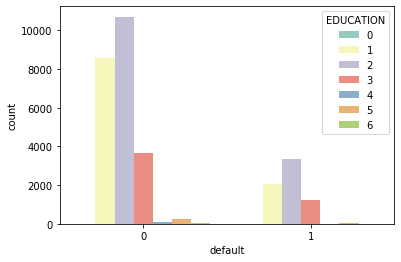

In [23]:
sns.countplot(x = 'default', hue = 'EDUCATION', data = data, palette="Set3")

Здесь явно не равномерное распределение. Преобладают 1, 2, 3. 

Нормализуем данные, разделив на полное количество людей в каждой группе, которые получали кредит

In [24]:
educ = np.zeros(7)

for ed in range(7):
    educ[ed] = data[data.EDUCATION == ed].default.sum() / data[data.EDUCATION == ed].default.size
educ       

array([0.        , 0.19234766, 0.23734854, 0.25157616, 0.05691057,
       0.06428571, 0.15686275])

Text(0.5, 1.0, 'Loan return by education')

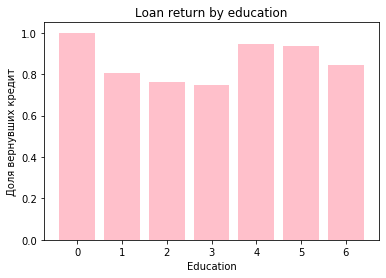

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
rect = ax.bar(range(7), 1 - educ, color='pink')

ax.set_xlabel('Education')
ax.set_ylabel('Доля вернувших кредит')
ax.set_title('Loan return by education')

In [26]:
sizes = np.zeros(7)

for i in range(0, 7):
    sizes[i] = data[data.EDUCATION == i].size
    
print(sizes)
print(1 - educ)

[3.50000e+02 2.64625e+05 3.50750e+05 1.22925e+05 3.07500e+03 7.00000e+03
 1.27500e+03]
[1.         0.80765234 0.76265146 0.74842384 0.94308943 0.93571429
 0.84313725]


Данных по людям с образованием '0 = доктор' мало и все из них вернули кредит. Если не учитывать данные по этим людям, потому что этих данных очень мало по сравнению с другим, то можно предположить, что люди с образованием "4 = начальное образование" наиболее вероятно вернут кредит, а наименее вероятно с образованием "3 = выпускник школы"

Но количество данных по этим типам людей также очень чильно различается

#### Составим таблицу сопряженности

- Нулевая гипотеза $H_0$: default и EDUCATION независимы
- Альтернатива $H_1$: $H_0$ не верна

Не буду учитывать образование "0"

In [27]:
diff_by_educ = np.array([])
diff1 = data[(data.EDUCATION == 1) & (data.default == 1)].shape[0] 
diff2 = data[(data.EDUCATION == 1) & (data.default == 0)].shape[0] 
diff_by_educ = (np.append(diff1, diff2)).reshape((2,1)) 

for educ in range(2, 7): 
    diff1 = data[(data.EDUCATION == educ) & (data.default == 1)].shape[0] 
    diff2 = data[(data.EDUCATION == educ) & (data.default == 0)].shape[0] 
    k = (np.append(diff1, diff2)).reshape((2,1)) 
    diff_by_educ = np.concatenate((diff_by_educ, k), axis=1) 

diff_by_educ

array([[ 2036,  3330,  1237,     7,    18,     8],
       [ 8549, 10700,  3680,   116,   262,    43]])

In [28]:
def cramers_stat(confusion_matrix): 
    chi2 = scipy.stats.chi2_contingency(confusion_matrix, correction= True)[0]
    n = confusion_matrix.sum() 
    return np.sqrt(1.*chi2 / (n*(min(confusion_matrix.shape)-1))) 

print("Cramer V: ", cramers_stat(diff_by_educ), " p-value: ", 
       scipy.stats.chi2_contingency(diff_by_educ, correction= True)[1])

Cramer V:  0.07286047087405424  p-value:  1.4764557605044473e-32


Нулевая гипотеза уверенно отвергается

### 4. Семейное положение (MARRIAGE): 
Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

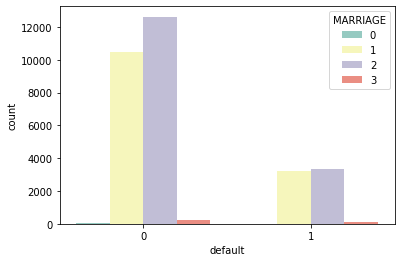

In [29]:
sns.countplot(x = 'default', hue = 'MARRIAGE', data = data, palette="Set3")

In [30]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Количество людей с 0 и 3 очень маленькое

Попробуем нормализовать, как в случае с EDUCATION

In [35]:
mar = np.zeros(4);

for m in range(4):
    mar[m] = data[data.MARRIAGE == m].default.sum() / data[data.MARRIAGE == m].default.size
    
1 - mar

array([0.90740741, 0.76528296, 0.79071661, 0.73993808])

Text(0.5, 1.0, 'Loan return by marriage')

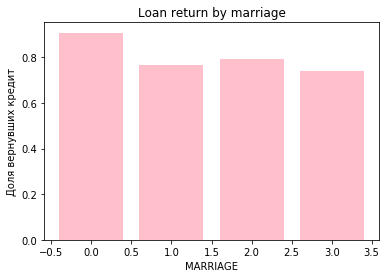

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
rect = ax.bar(range(4), 1 - mar, color='pink')

ax.set_xlabel('MARRIAGE')
ax.set_ylabel('Доля вернувших кредит')
ax.set_title('Loan return by marriage')

#### Составим таблицу сопряженности

- Нулевая гипотеза $H_0$: default и MARRIAGE независимы
- Альтернатива $H_1$: $H_0$ не верна

In [37]:
diff_by_mar = np.array([])
diff1 = data[(data.MARRIAGE == 0) & (data.default == 1)].shape[0]
diff2 = data[(data.MARRIAGE == 0) & (data.default == 0)].shape[0]
diff_by_mar = (np.append(diff1, diff2)).reshape((2,1))

for m in range(1, 4):
    diff1 = data[(data.MARRIAGE == m) & (data.default == 1)].shape[0] 
    diff2 = data[(data.MARRIAGE == m) & (data.default == 0)].shape[0] 
    k = (np.append(diff1, diff2)).reshape((2,1)) 
    diff_by_mar = np.concatenate((diff_by_mar, k), axis=1)
    
diff_by_mar

array([[    5,  3206,  3341,    84],
       [   49, 10453, 12623,   239]])

In [38]:
def cramers_stat(confusion_matrix): 
    chi2 = scipy.stats.chi2_contingency(confusion_matrix, correction= True)[0]
    n = confusion_matrix.sum() 
    return np.sqrt(1.*chi2 / (n*(min(confusion_matrix.shape)-1))) 

print("Cramer V: ", cramers_stat(diff_by_mar), " p-value: ", 
       scipy.stats.chi2_contingency(diff_by_mar, correction= True)[1])

Cramer V:  0.034478203662766466  p-value:  8.825862457577375e-08


P-value очень маленький, поэтому нулевая гипотеза о независимости default и MARRIAGE уверенно отвергается

В отличие от случая с EDUCATION p-value намного больше для MARRIAGE, и значит этот признак более значим, однако он все равно очень мал

### 5. Возраст (AGE): 
Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 

    a) о равенстве медианных значений возрастов людей 

    b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

Значимы ли полученные результаты с практической точки зрения ?

Будем дейстовать также как и в первом пункте

((array([-3.70801024, -3.47700165, -3.34989414, ...,  3.34989414,
          3.47700165,  3.70801024]),
  array([21, 21, 21, ..., 73, 73, 75])),
 (9.453763999193255, 35.72573839662447, 0.9748432681275314))

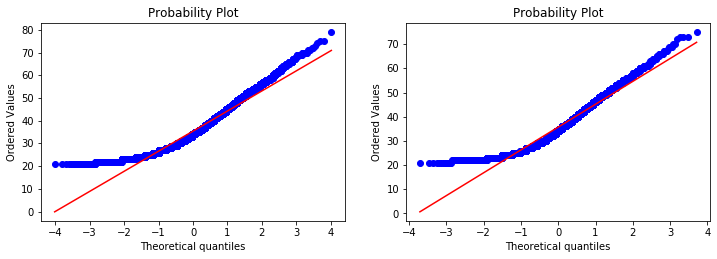

In [39]:
plt.figure(figsize = (12, 8))

plt.subplot(2, 2, 1)
stats.probplot(data[data.default == 0].AGE, dist="norm", plot=pylab)

plt.subplot(2, 2, 2)
stats.probplot(data[data.default == 1].AGE, dist="norm", plot=pylab)

Q-Q графики явно не прямые, значит распределения не являются нормальными

In [40]:
data.AGE.describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

Text(0, 0.5, 'Number')

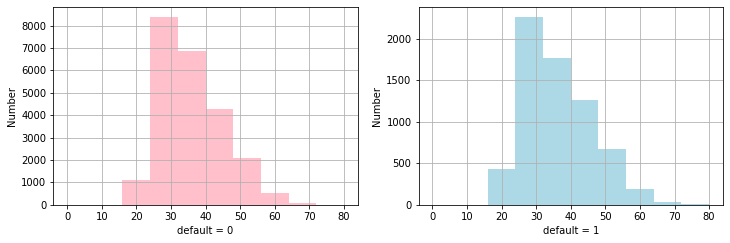

In [51]:
plt.figure(figsize = (12, 8))

plt.subplot(2,2,1)
plt.grid()
plt.hist(data[data.default == 0].AGE, color = 'pink', range = (0, 80))
plt.xlabel('default = 0')
plt.ylabel('Number')

plt.subplot(2,2,2)
plt.grid()
plt.hist(data[data.default == 1].AGE, color = 'lightblue', range = (0, 80))
plt.xlabel('default = 1')
plt.ylabel('Number')

Распределения выглядят очень похожими и пик у них находится примерно на одном уровне. Проверим эти догадки.

In [43]:
print('Default = 0: mean = %f, median = %f'% (data[data.default == 0].AGE.mean(),  
                                                data[data.default == 0].AGE.median()))
print('Default = 1: mean = %f, median = %f'% (data[data.default == 1].AGE.mean(),  
                                                data[data.default == 1].AGE.median()))

Default = 0: mean = 35.417266, median = 34.000000
Default = 1: mean = 35.725738, median = 34.000000


####  Доверительный интервал на основе бутстрепа

In [44]:
np.random.seed(0)

age_default_0 = data[data.default == 0].AGE.values
age_default_1 = data[data.default == 1].AGE.values

median_scores_0 = list(map(np.median, get_bootstrap_samples(age_default_0, 1000)))
median_scores_1 = list(map(np.median, get_bootstrap_samples(age_default_1, 1000)))

print("95% confidence interval for default = 0 median:",  stat_intervals(median_scores_0, 0.05))
print("95% confidence interval for default = 1 median:",  stat_intervals(median_scores_1, 0.05))

95% confidence interval for default = 0 median: [34. 34.]
95% confidence interval for default = 1 median: [34. 35.]


Доверительные интервалы пересекаются, поэтому нельзя утверждать, что есть разница медианных значений

In [45]:
delta_median_scores = list(map(lambda x: x[1] - x[0], zip(median_scores_1, median_scores_0)))

print("difference between medians:", np.median(age_default_0) - np.median(age_default_1))
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05))

difference between medians: 0.0
95% confidence interval for the difference between medians [-1.  0.]


5а. Доверительный интервал содержит 0, поэтому можно считать, что разница медианных значений статистически не значима

#### Проверим гипотезу о равенстве распределений с помощью рангового критерия Манна-Уитни

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [47]:
stats.mannwhitneyu(age_default_0, age_default_1)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

5b. P-value достаточно большой, поэтому мы не можем отвергнуть нулевую гипотезу.

С практической точки зрения эти результаты показывают, что возраст не оказывает влияния на возврат кредита